In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

#act_directory = '/Users/InsanallyLab/Desktop/Analysis_Cache'
act_directory = 'D:\\Analysis_Cache'
#act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

%run animal_info
ANIMAL = 'AC_12102016'

#animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']

dualanimals = ['BS_174','BS_179','BS_191','BS_192']
retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
didlearnopsinanimals = ['BS_92','BS_103','BS_111','BS_179']
didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminateopsinanimals = ['BS_139','BS_165','BS_191','BS_192']

In [2]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
# for session in tqdm(os.listdir(ops_directory)):
#     sessionfile = ilep.loadSessionCached(ops_directory,session)
#     animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
# for session in tqdm(os.listdir(ops_directory)):
#     sessionfile = ilep.loadSessionCached(ops_directory,session)
#     if sessionfile.meta.region != 'AC':
#         continue
#     training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
print(animals_in_cache)

100%|██████████| 592/592 [00:02<00:00, 199.15it/s]

['AE_229' 'AE_231' 'AE_235' 'AE_236' 'BS_108' 'BS_113' 'BS_173' 'BS_175'
 'BS_187' 'BS_188' 'BS_213' 'BS_214' 'BS_33' 'BS_40' 'BS_41' 'BS_42'
 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67' 'BS_70' 'BS_72' 'BS_73'
 'BS_78' 'BS_83' 'BS_85' 'BS_87' 'BS_95' 'DS_13' 'DS_15' 'DS_16' 'DS_17'
 'DS_19' 'DS_22' 'DS_23' 'DS_24' 'DS_27' 'DS_28' 'LA_204' 'LA_205'
 'TH_200' 'TH_201' 'TH_203' 'TH_217' 'TH_230' 'TH_233' 'TH_234' 'TH_237']


In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

In [4]:
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

animals = tuninganimalnames
#animals = danimals
#animals = tuninganimalnames

['BS_61']
['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']


['BS_40',
 'BS_41',
 'BS_42',
 'BS_49',
 'BS_50',
 'BS_51',
 'BS_56',
 'BS_59',
 'BS_61',
 'BS_67',
 'BS_70',
 'BS_72',
 'BS_87',
 'BS_108',
 'DS_15',
 'DS_19']

In [5]:
def getExpertDays(animalBehaviors,animal):
    days = np.sort([k for k in animalBehaviors[animal].sessions])
    num_days = np.max(days)#len(days)
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    #############################################################
    #                   Find prereversal expert                 #
    #############################################################
    
    pre_expert_days = []
    
    if np.isfinite(reversal):
        days_to_check = np.sort(list(range(1,reversal)))[::-1]
    else:
        days_to_check = np.sort(list(range(1,num_days+1)))[::-1]
        reversal = np.max(days_to_check)+1
    days_to_check = days_to_check[np.isin(days_to_check,list(animalBehaviors[animal].sessions.keys()))]
    for day in days_to_check:
        outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
        
        exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
        if exceptionTrials is None:
            valid_trials_mask = ilep.getActiveTrials(outcomes)
        else:
            valid_trials_mask = exceptionTrials
        trimmed_outcomes = outcomes[valid_trials_mask]
        
        PCt,dpt = ilep.pcdpFromOutcomes(trimmed_outcomes)
        
        if PCt >= 0.7 and dpt >= 1.5:
            if np.isfinite(reversal):
                [pre_expert_days.append(d) for d in list(range(day,reversal+1))]
            else:
                [pre_expert_days.append(d) for d in list(range(day,np.max(days_to_check)+1))]
        elif day != days_to_check[0]:
            pass#break
    #if len(pre_expert_days)>0:
    #    pre_expert_days = np.concatenate((pre_expert_days))
    pre_expert_days = np.sort(np.unique(pre_expert_days))[::-1]
    pre_expert_days = pre_expert_days[np.isin(pre_expert_days,list(animalBehaviors[animal].sessions.keys()))]
        
    ############### Exceptions for specific animals ##################
    
    if animal == 'BS_40':
        pre_expert_days = np.array([17,16])
    if animal == 'BS_42':
        pre_expert_days = np.array([6,5])
    if animal == 'BS_50':
        pre_expert_days = np.array([11,10])
        
    #############################################################
    #                  Find postreversal expert                 #
    #############################################################
    
    if not np.isfinite(reversal):
        return pre_expert_days,[]
    
    post_expert_days = []
    days_to_check = np.sort(list(range(reversal+1,num_days+1)))[::-1]
    days_to_check = days_to_check[np.isin(days_to_check,list(animalBehaviors[animal].sessions.keys()))]
    for day in days_to_check:
        outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
        valid_trials_mask = ilep.getActiveTrials(outcomes)
        trimmed_outcomes = outcomes[valid_trials_mask]
        
        PCt,dpt = ilep.pcdpFromOutcomes(trimmed_outcomes)
        
        if PCt >= 0.7 and dpt >= 1.5:
            #post_expert_days.append(day)
            #if day == days_to_check[1]:
            [post_expert_days.append(d) for d in list(range(day,num_days+1))]
                #post_expert_days.append(day+1)
        elif day != days_to_check[0]:
            pass#break
    #if len(post_expert_days)>0:
    #    post_expert_days = np.concatenate((post_expert_days))
    post_expert_days = np.sort(np.unique(post_expert_days))[::-1]
    post_expert_days = post_expert_days[np.isin(post_expert_days,list(animalBehaviors[animal].sessions.keys()))]
        
    ############### Exceptions for specific animals ##################
    
    if animal == 'BS_49':
        post_expert_days = np.array([20,19,18])
    if animal == 'DS_28':
        post_expert_days = np.array([35])
        
    return pre_expert_days,post_expert_days

In [6]:
def getPCDPfromBehavior(animalBehaviors,animal,days,expert):
    cond = np.full_like(days,np.nan,dtype='float')
    cond_pc = np.full_like(days,np.nan,dtype='float')
    if not animal in animalBehaviors:
        return cond,cond_pc
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
        
    #We will remove the duplicate reversal day because we will calculate both
    #pre and post reversal when we get there at once
    days = np.unique(days)
    
    for idx,day in enumerate(days):
        if not day in animalBehaviors[animal].sessions:
            continue
            
        #We still want to put the post-reversal days in the right place, so we have to account
        #for the double reversal day
        if hasattr(animalBehaviors[animal],'reversal') and day > animalBehaviors[animal].reversal:
            idx+=1
            
        ########## Pre/Postreversal ##########
        if day != reversal:
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            #We will trim for active trials only on expert days
            exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
            if not exceptionTrials is None:
                pass#print(f"Trimming via exception trials")
                valid_trials_mask = exceptionTrials
                outcomes = outcomes[valid_trials_mask]
            elif day in expert:
                valid_trials_mask = ilep.getActiveTrials(outcomes)
                outcomes = outcomes[valid_trials_mask]

            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))

            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            #print(dp)
            if not exceptionTrials is None:
                pass#print(f"PC is {pc} dp is {dp}")

            cond[idx] = dp
            cond_pc[idx] = pc
            
        ########## Switch ##########
        if day == reversal:
            trials_per_session = animalBehaviors[animal].sessions[day].trials_per_session
            pre_reversal_trials = range(int(trials_per_session[0]))
            post_reversal_trials = range(int(trials_per_session[0]),int(np.sum(trials_per_session)))
            
            #Prereversal
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            outcomes = outcomes[pre_reversal_trials]
            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))
            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            cond[idx] = dp
            cond_pc[idx] = pc

            #Postreversal
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            outcomes = outcomes[post_reversal_trials]
            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))
            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            cond[idx+1] = dp
            cond_pc[idx+1] = pc
            
    return cond,cond_pc

BS_173
BS_175
BS_187
BS_188
BS_213
BS_214
TH_217
AE_235
AE_236
TH_237


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


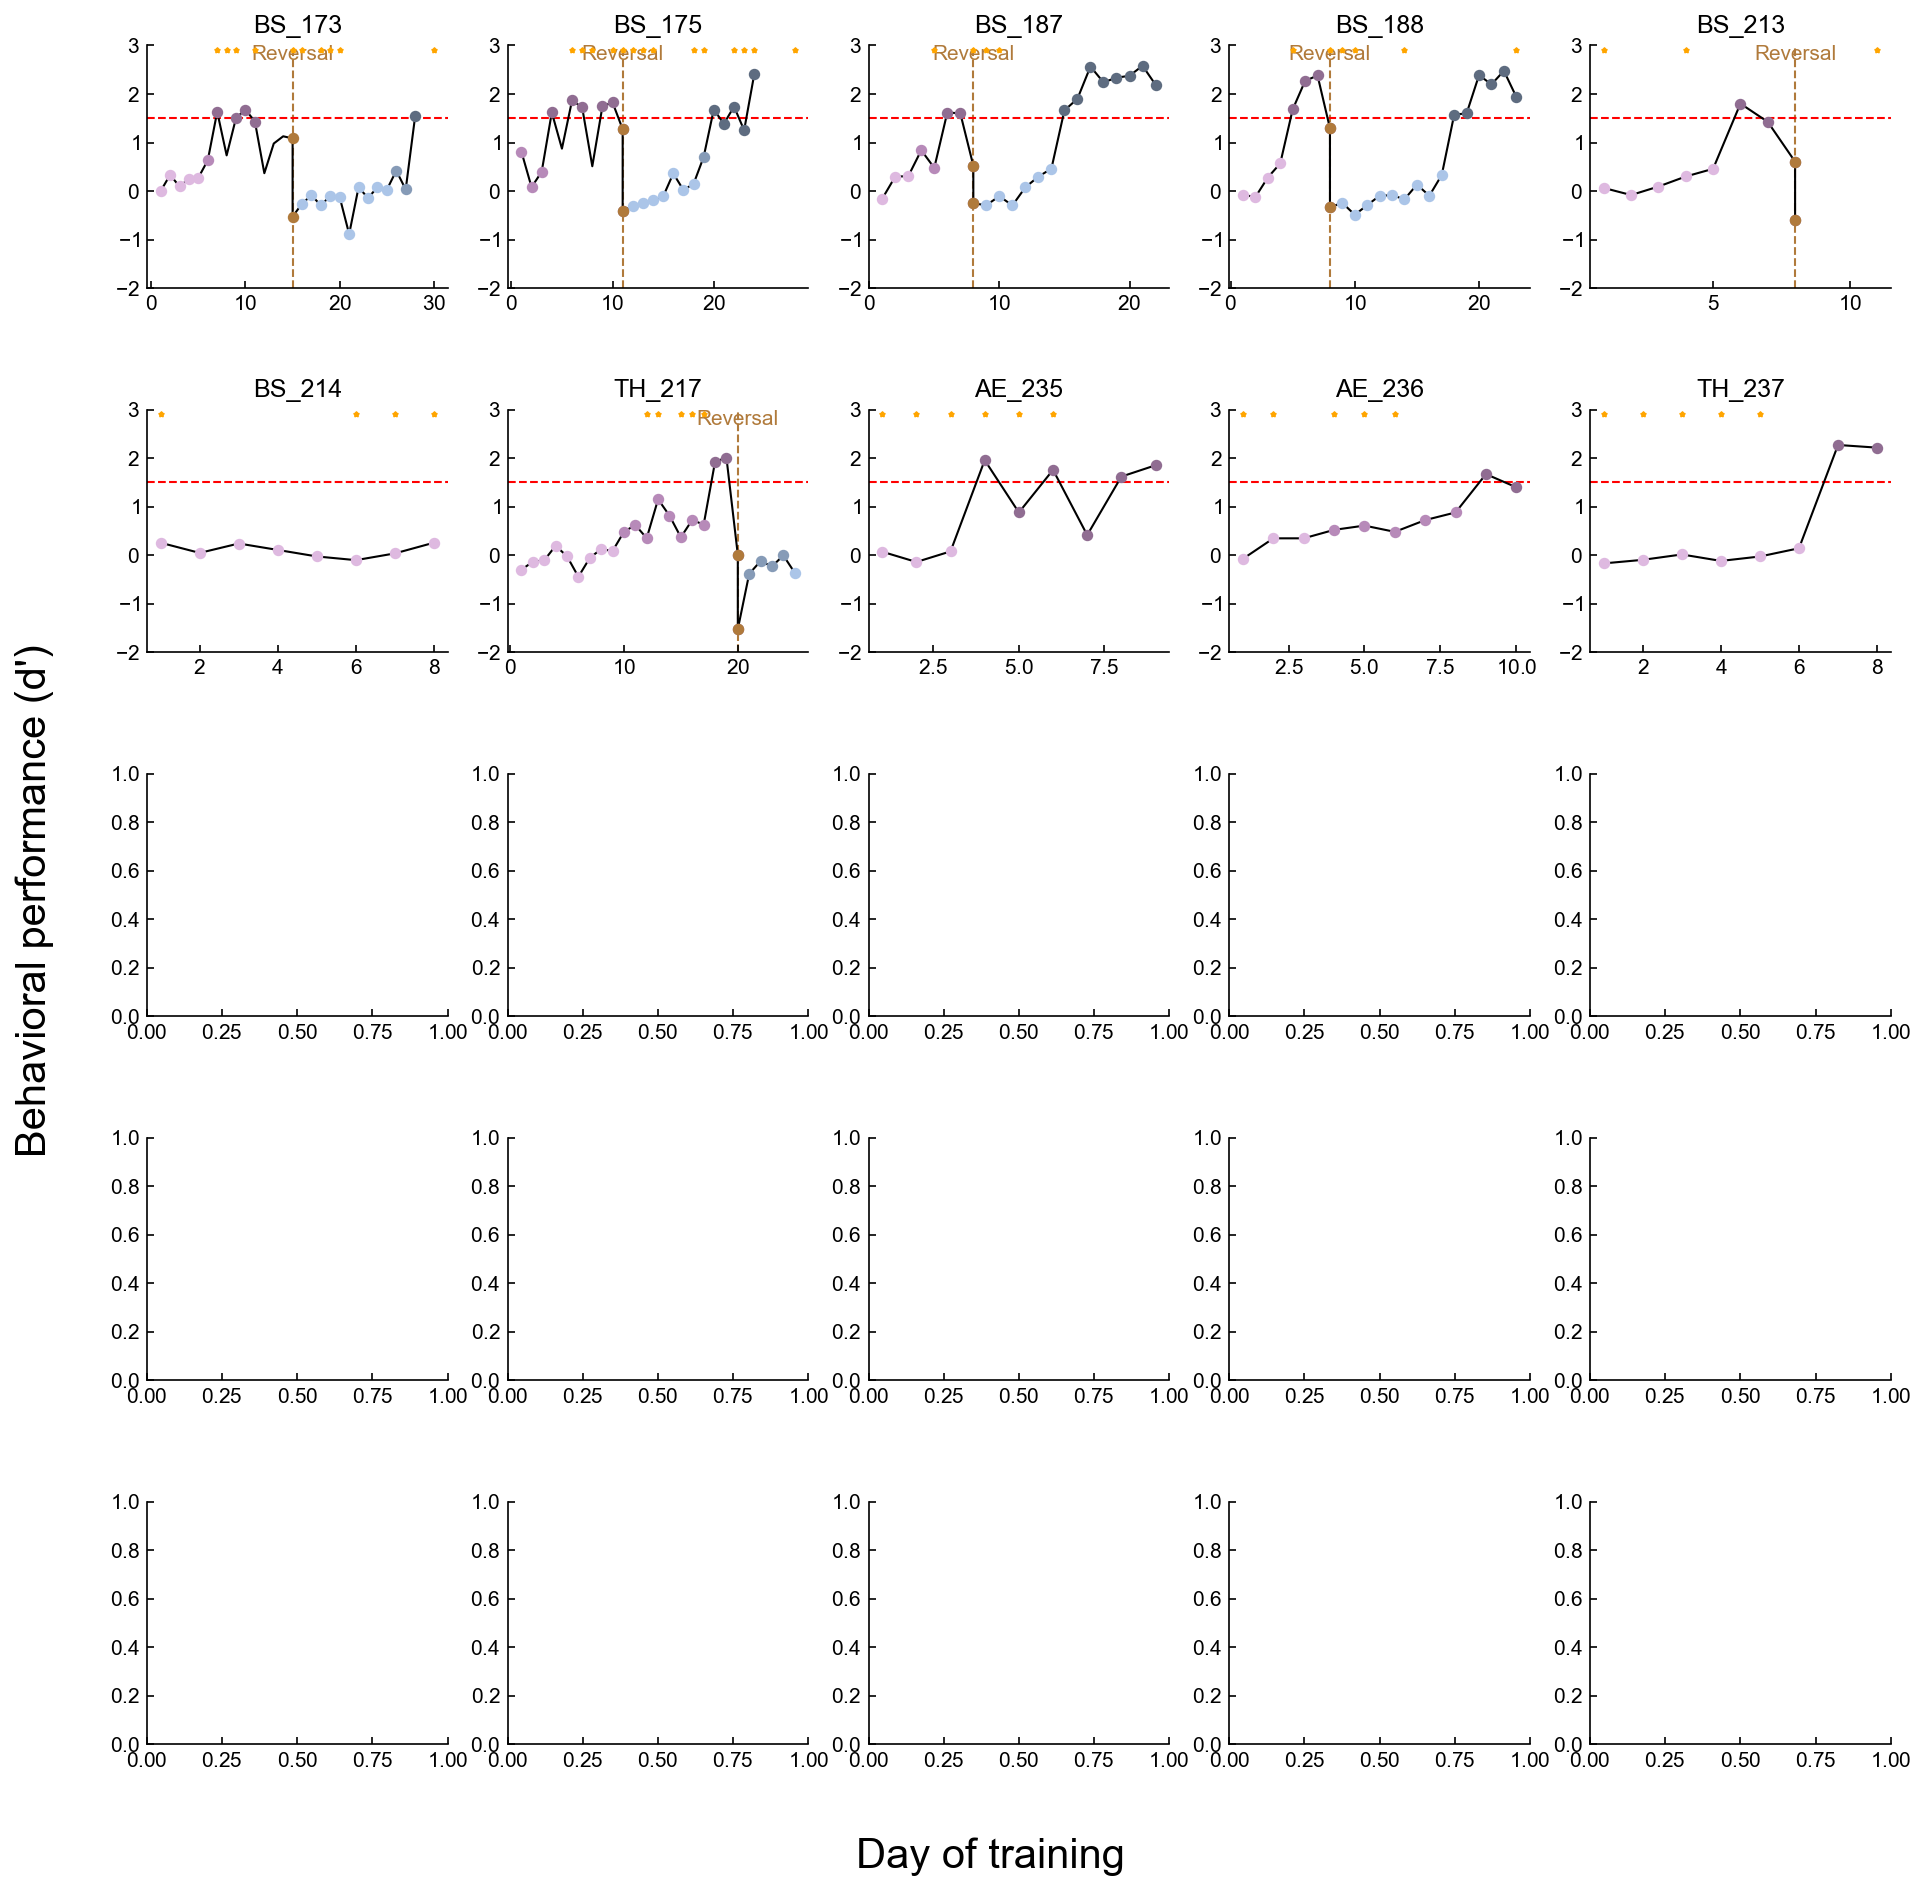

In [7]:
animalPhases = dict()

animalPreThresh = dict()
animalPostThresh = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(5,5,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(5),range(5))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

for animalidx,animal in enumerate(animals):
    print(animal)
    
    animalPhases[animal] = SimpleNamespace()
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    days = [k for k in animalBehaviors[animal].sessions]
    if np.isfinite(reversal):
        days.append(reversal)
    days = np.sort(days)
    
    if animal == 'BS_49':
        print(animalBehaviors[animal].reversal)
        print(reversal)
        print(days)
    
    pre_exp,post_exp = getExpertDays(animalBehaviors,animal)
    expert_days = np.concatenate((pre_exp,post_exp))
    dp_list,pc_list = getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
            
    ############### Calculation of learning phases ###################
    
    pre_reversal_days_mask = np.less(days,reversal)
    post_reversal_days_mask = np.greater(days,reversal)
    
    pre_reversal_dp_list = dp_list[pre_reversal_days_mask]
    post_reversal_dp_list = dp_list[post_reversal_days_mask]
    if np.isfinite(reversal):
        pre_switch_dp = dp_list[reversal-1]
        post_switch_dp = dp_list[reversal]
    else:
        pre_switch_dp = dp_list[len(dp_list)-1]
        post_switch_dp = []
        
#     print(f"reversal at {reversal}")
#     print(f"pre_reversal list is {pre_reversal_dp_list}")
    
    pre_rev_dp_concat = pre_reversal_dp_list#np.concatenate((pre_reversal_dp_list,pre_switch_dp))
    pre_rev_min = min(np.min(pre_reversal_dp_list),0)
    pre_rev_max = max(np.max(pre_reversal_dp_list),1.5)
    pre_reversal_dp_thresh = pre_rev_min + 0.3 * (pre_rev_max - pre_rev_min)
    post_rev_dp_concat = pre_reversal_dp_list#np.concatenate((post_reversal_dp_list,post_switch_dp))
#     print(f"post_rev dp list is {post_reversal_dp_list}")
    try:
        #post_rev_min = min(np.min(post_reversal_dp_list),0)
        post_rev_min = post_switch_dp
        post_rev_max = max(np.max(post_reversal_dp_list),1.5)
        post_reversal_dp_thresh = post_rev_min + 0.3 * (post_rev_max - post_rev_min)
    except:
        post_rev_min = np.nan
        post_rev_max = np.nan
        post_reversal_dp_thresh = np.Inf
        
    animalPreThresh[animal] = pre_reversal_dp_thresh
    animalPostThresh[animal] = post_reversal_dp_thresh

    pre_late_days_mask = np.greater_equal(pre_reversal_dp_list,pre_reversal_dp_thresh)
    post_late_days_mask = np.greater_equal(post_reversal_dp_list,post_reversal_dp_thresh)
    
    ############ Export final results to a list of days ############
    
    pre_reversal_days = np.where(pre_reversal_days_mask)[0] + 1
    post_reversal_days = np.where(post_reversal_days_mask)[0] # No +1 because double reversal day
    
    pre_expert_days = np.sort(pre_exp)
    post_expert_days = np.sort(post_exp)
    
    pre_late_days = np.where(pre_late_days_mask)[0] + 1
    post_late_days = np.where(post_late_days_mask)[0] + 1 + reversal # No +1 because adding reversal. +1 because double reversal
    
#     print(f"pre_reversal list is {pre_reversal_dp_list}")
#     print(f"post_reversal list is {post_reversal_dp_list}")
#     print(f"pre_late days are {pre_late_days}")
#     print(f"post_late days are {post_late_days}")
    
    if len(pre_late_days)>0:
        last_day_late = reversal
        if not np.isfinite(reversal):
            last_day_late = np.max(days)
#             print(f"last day = {last_day_late}")
        pre_late_days = np.arange(np.min(pre_late_days),last_day_late)
    if len(post_late_days)>0:
        post_late_days = np.arange(np.min(post_late_days),max(days))
    pre_late_days = pre_late_days[np.logical_not(np.isin(pre_late_days,pre_expert_days))]
    post_late_days = post_late_days[np.logical_not(np.isin(post_late_days,post_expert_days))]
    
    pre_early_days = pre_reversal_days[np.logical_not(np.isin(pre_reversal_days,pre_late_days))]
    post_early_days = post_reversal_days[np.logical_not(np.isin(post_reversal_days,post_late_days))]
    pre_early_days = pre_early_days[np.logical_not(np.isin(pre_early_days,pre_expert_days))]
    post_early_days = post_early_days[np.logical_not(np.isin(post_early_days,post_expert_days))]
    
    if False:#animal in ['BS_49']:
        print(animal)
        print(f"reversal is {reversal}")
        print(f"dps are {dp_list}")

        print(f"Pre-reversal days mask: {pre_reversal_days_mask}")
        print(f"Post-reversal days mask: {post_reversal_days_mask}")

        print(f"Pre-reversal dps: {pre_reversal_dp_list}")
        print(f"Post-reversal dps: {post_reversal_dp_list}")

        print(f"Pre-reversal threshold: {pre_reversal_dp_thresh}")
        print(f"Post-reversal threshold: {post_reversal_dp_thresh}")

        print(f"Pre-reversal days: {pre_reversal_days}")
        print(f"Post-reversal days: {post_reversal_days}")

        print(f"Pre-early days: {pre_early_days}")
        print(f"Post-early days: {post_early_days}")

        print(f"Pre-late days: {pre_late_days}")
        print(f"Post-late days: {post_late_days}")

        print(f"Pre-expert days: {pre_expert_days}")
        print(f"Post-expert days: {post_expert_days}")
        
    #Handle one particular exception for BS_50 due to animal not behaving
    if animal == 'BS_50':
        pre_early_days = list(pre_early_days)
        pre_late_days = list(pre_late_days)
        pre_late_days.remove(5)
        #I have verified that day is is below the pre-threshold
        pre_late_days.remove(6)
        pre_early_days.append(6)
        pre_early_days = np.sort(pre_early_days)
        pre_late_days = np.sort(pre_late_days)
    if animal == 'BS_173':
        pre_expert_days = np.array([7,9,10,11])
    if animal == 'BS_175':
        pre_expert_days = np.array([4,6,7,9,10,11])
        
    animalPhases[animal].pre_early_days = pre_early_days
    animalPhases[animal].pre_late_days = pre_late_days
    animalPhases[animal].pre_expert_days = pre_expert_days
    if np.isfinite(reversal):
        animalPhases[animal].switch_days = [reversal]
    else:
        animalPhases[animal].switch_days = []
    animalPhases[animal].post_early_days = post_early_days
    animalPhases[animal].post_late_days = post_late_days
    animalPhases[animal].post_expert_days = post_expert_days
    
    #PLOTTING_PHASE_COLORS = ['k','r','g']*2
    PLOTTING_PHASE_COLORS = PHASE_COLORS
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,dp_list,color='k',lw=1)
        
        #Pre Early
        pre_early = np.isin(days,pre_early_days)
        ax.scatter(days[pre_early],dp_list[pre_early],color=PLOTTING_PHASE_COLORS[0],s=20,zorder=10)
        
        #Pre Late
        pre_late = np.isin(days,pre_late_days)
        ax.scatter(days[pre_late],dp_list[pre_late],color=PLOTTING_PHASE_COLORS[1],s=20,zorder=10)
        #ax.axhline(animalPreThresh[animal],c=PHASE_COLORS[1],linestyle='--',lw=1,zorder=-20)
        
        #Pre Expert
        pre_expert = np.isin(days,pre_expert_days)
        ax.scatter(days[pre_expert],dp_list[pre_expert],color=PLOTTING_PHASE_COLORS[2],s=20,zorder=10)
        
        #Post Early
        post_early = np.isin(days,post_early_days)
        ax.scatter(days[post_early],dp_list[post_early],color=PLOTTING_PHASE_COLORS[3],s=20,zorder=10)
        
        #Post Late
        post_late = np.isin(days,post_late_days)
        ax.scatter(days[post_late],dp_list[post_late],color=PLOTTING_PHASE_COLORS[4],s=20,zorder=10)
        #ax.axhline(animalPostThresh[animal],c=PHASE_COLORS[4],linestyle='--',lw=1,zorder=-20)
        
        #Post Expert
        post_expert = np.isin(days,post_expert_days)
        ax.scatter(days[post_expert],dp_list[post_expert],color=PLOTTING_PHASE_COLORS[5],s=20,zorder=10)
        
        #Switch
        switch = np.equal(days,reversal)
        ax.scatter(days[switch],dp_list[switch],color=SWITCH_COLOR,s=20,zorder=10)
        #ax.scatter(days[switch],dp_list[switch],color='b',s=20,zorder=10)

        ax.set_ylim([-2,3])
        
        ax.text(reversal,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
        ax.axvline(reversal,c=SWITCH_COLOR,linestyle='--',lw=1,zorder=-10)
        
        ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-10)
        
        ax.set_title(animal)
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)
        
        if animal in ['DS_15']:
            pass#ax.text(1,-1.5,'NOTE: lost behavior data',verticalalignment='bottom',horizontalalignment='left')
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    #plt.savefig(os.path.join('D:\\\\TempFigures','Automated Learning Phases 2.pdf'),transparent=False,facecolor="white")
    #plt.savefig(os.path.join('D:\\\\TempFigures','Automated Learning Phases 2 Danimals.pdf'),transparent=False,facecolor="white")
    #plt.savefig(os.path.join('D:\\\\TempFigures','Automated Learning Phases 2 Tuning Animals.pdf'),transparent=False,facecolor="white")
    pass

In [8]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    if session in ['TH_217_4_tuning_AC.pickle']:
        continue
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task not in ['tuning nonreversal', 'tuning switch', 'tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in tuninganimalnames:
        continue
    
    sessionfile = ilep.determineTuningCurveTones(sessionfile)
    if ilep.testInOrderTonePresentation(sessionfile):
        continue
    for clust in sessionfile.clusters.good:
        if sessionfile.tuning.number_of_tones <= 0 or len(sessionfile.trim[clust].trimmed_tuning_trials) / len(np.unique(sessionfile.tuning.trial_freqs)) < 30:
            continue
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 592/592 [00:03<00:00, 193.67it/s]


In [9]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and animal in ['DS_15','DS_19']:
            EILphases[idx] = 'pre expert'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in animalPhases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in animalPhases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in animalPhases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and animal in ['DS_15','DS_19']:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1054/1054 [00:15<00:00, 68.25it/s]

errors for: []


In [10]:
def CalculateBestFrequencies(sessionfile,clust):
    tones_to_consider = np.sort(np.unique(sessionfile.tuning.trial_freqs))
    tuning_FRs = np.full_like(tones_to_consider,np.nan)

    clust_spikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    for idx,tone in enumerate(tones_to_consider):

        #tone_trials = np.equal(sessionfile.tuning.trial_freqs,tone)
        #tone_trials = np.where(tone_trials)[0]
        #
        #this_tone_FRs = []
        #for trial in tone_trials:

            #trialstart = sessionfile.tuning.trial_starts[trial]

            #trial_spikes = len(ilep.getSpikeTimes(sessionfile,cachedtimes = clust_spikes,starttime = trialstart, endtime = trialstart+0.2*sessionfile.meta.fs))
            #trial_FR = trial_spikes / 0.2
            #this_tone_FRs.append(trial_FR)

        ##print(str(tone) + ': ' + str(this_tone_FRs))
        #tuning_FRs[idx] = np.mean(this_tone_FRs)
        
        FRevoked = sessionfile.tuning.tuning_responsiveness[clust][str(tone)].FRevoked
        if not np.isfinite(FRevoked):
            return []
        tuning_FRs[idx] = FRevoked
    
    maxidxs = np.argwhere(tuning_FRs >= np.max(tuning_FRs)*1)
    best_frequencies = tones_to_consider[maxidxs]
    best_frequencies = np.concatenate(best_frequencies)
    return best_frequencies

def plotTuningCurve(sessionfile,clust):
    tones_to_use = np.sort(np.unique(sessionfile.tuning.trial_freqs))
    tuning_FRs = np.full_like(tones_to_use,np.nan)
    tuning_FR_SEMs = np.full_like(tones_to_use,np.nan)

    clust_spikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    for idx,tone in enumerate(tones_to_use):

        tone_trials = np.equal(sessionfile.tuning.trial_freqs,tone)
        tone_trials = np.where(tone_trials)[0]

        this_tone_FRs = []
        for trial in tone_trials:

            trialstart = sessionfile.tuning.trial_starts[trial]

            trial_spikes = len(ilep.getSpikeTimes(sessionfile,cachedtimes = clust_spikes,starttime = trialstart, endtime = trialstart+0.2*sessionfile.meta.fs))
            trial_FR = trial_spikes / 0.2
            this_tone_FRs.append(trial_FR)

        #print(str(tone) + ': ' + str(this_tone_FRs))
        tuning_FRs[idx] = np.mean(this_tone_FRs)
        tuning_FR_SEMs[idx] = sem(this_tone_FRs)
        
    best_frequencies = CalculateBestFrequencies(sessionfile,clust)
    best_frequency_idxs = np.concatenate([np.argwhere(tones_to_use == f)[0] for f in best_frequencies])

    fig,ax = plt.subplots(figsize=(5,3))
    ax.plot(range(len(tuning_FRs)),tuning_FRs,color=GOOD_GREY,lw=1)
    ax.fill_between(range(len(tuning_FRs)),tuning_FRs-tuning_FR_SEMs,tuning_FRs+tuning_FR_SEMs,color=GOOD_GREY,alpha=0.125,lw=0,zorder=-10)
    ax.scatter(range(len(tuning_FRs)),tuning_FRs,color=GOOD_GREY,s=10)
    ax.scatter(best_frequency_idxs,tuning_FRs[best_frequency_idxs],color=GOOD_GREEN,s=50,zorder=10,label='best frequency')

    ax.set_xlabel('Tone Frequency (Hz)')
    ax.set_xticks(range(len(tuning_FRs)))
    ax.set_xticklabels(tones_to_use)
    ax.set_xlim([0,len(tuning_FRs)-1])

    ax.set_ylabel('Firing rate (spikes/s)')
    max_FR_value = np.max(tuning_FRs) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax.set_ylim([0,limit])
    ax.set_yticks([0,limit/2,limit])
    ax.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    
    ax.legend(frameon=False,loc='upper right')
    
    return fig

In [11]:
pre_early_FRmod = []

pre_early_best_freqs = []
pre_early_weights = []

pre_late_best_freqs = []
pre_late_weights = []

pre_expert_best_freqs = []
pre_expert_weights = []

post_early_best_freqs = []
post_early_weights = []

post_late_best_freqs = []
post_late_weights = []

post_expert_best_freqs = []
post_expert_weights = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    sessionfile = ilep.determineTuningCurveTones(sessionfile)
    
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','AE_235','AE_236','TH_237']:
        continue
        
    if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if ilep.testInOrderTonePresentation(sessionfile):
        continue
        
    if len(np.unique(sessionfile.tuning.trial_freqs)) < 7:
        continue
    
    best_freqs = CalculateBestFrequencies(sessionfile,clust)
    weights = np.ones_like(best_freqs) / len(best_freqs)
    
    
    if EILphases[idx] == 'pre early':
        pre_early_FRmod.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        pre_early_best_freqs.append(best_freqs)
        pre_early_weights.append(weights)
    if EILphases[idx] == 'pre late':
        pre_late_best_freqs.append(best_freqs)
        pre_late_weights.append(weights)
    if EILphases[idx] == 'pre expert':
        pre_expert_best_freqs.append(best_freqs)
        pre_expert_weights.append(weights)
    if EILphases[idx] == 'post early':
        post_early_best_freqs.append(best_freqs)
        post_early_weights.append(weights)
    if EILphases[idx] == 'post late':
        post_late_best_freqs.append(best_freqs)
        post_late_weights.append(weights)
    if EILphases[idx] == 'post expert':
        post_expert_best_freqs.append(best_freqs)
        post_expert_weights.append(weights)


pre_early_best_freqs = np.concatenate(pre_early_best_freqs)
pre_early_weights = np.concatenate(pre_early_weights)
pre_late_best_freqs = np.concatenate(pre_late_best_freqs)
pre_late_weights = np.concatenate(pre_late_weights)
pre_expert_best_freqs = np.concatenate(pre_expert_best_freqs)
pre_expert_weights = np.concatenate(pre_expert_weights)
post_early_best_freqs = np.concatenate(post_early_best_freqs)
post_early_weights = np.concatenate(post_early_weights)
post_late_best_freqs = np.concatenate(post_late_best_freqs)
post_late_weights = np.concatenate(post_late_weights)
post_expert_best_freqs = np.concatenate(post_expert_best_freqs)
post_expert_weights = np.concatenate(post_expert_weights)

1054it [00:16, 62.40it/s]


In [12]:
print(np.median(pre_early_FRmod))

4.472962218312809


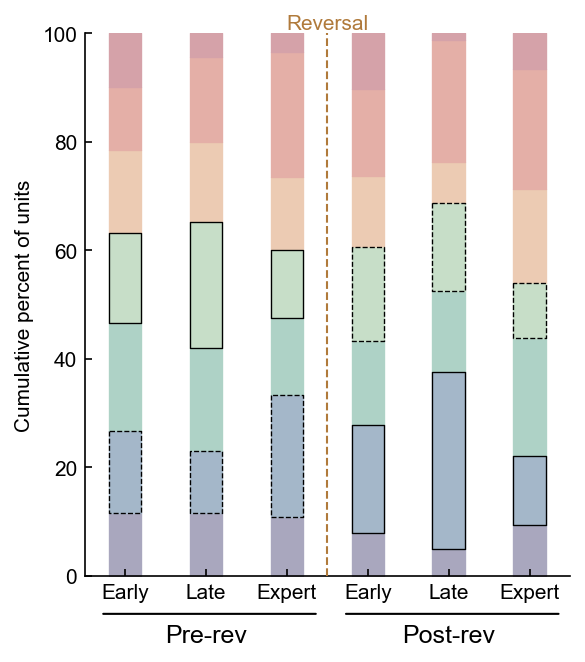

In [13]:
def plotBestFreqStack(ax,x,ylims,best_freqs,weights,width = 0.4,tntls=['-','-']):
    tones_250 = [4000,8000,16000,32000,64000]
    tones_350 = [4000,5648,8000,11260,16000,32000,64000]
    tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
    freqs_to_consider = tones_350
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = cmap(np.linspace(0,1,len(freqs_to_consider)))
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
    #colors_to_use = mpl.colors.Colormap('plasma',len(freqs_to_consider))
    
    total_weight = 0
    for tone in freqs_to_consider:
        this_tone_idx = np.equal(best_freqs,tone)
        total_weight += np.sum(weights[this_tone_idx])
        
    current_total = 0
    last_breakpoints = []
    breakpoints = [0]
    for idx,tone in enumerate(freqs_to_consider):
        this_tone_idx = np.equal(best_freqs,tone)
        this_tone_weight = np.sum(weights[this_tone_idx])
        if tone == 5648:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65,linestyle=tntls[0],edgecolor='k',zorder=10)#,hatch='XXXXXX'
        elif tone == 11260:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65,linestyle=tntls[1],edgecolor='k',zorder=10)
        else:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
        current_total += this_tone_weight
        breakpoints.append(current_total)
        
    return (breakpoints/total_weight)

def plotConnectingLines(breakpre,breakpost,X,width=0.125):
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    #colors_to_use = ['#b6888e','#80689D','#3d85c6','#78a5af','#78b0ac','#a4b49c','#4d4c55']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
        
        Y1 = [breakpre[idx],breakpost[idx]]
        Y2 = [breakpre[idx+1],breakpost[idx+1]]
        Xplot = [X[0]+width,X[1]-width]
        
        ax.fill_between(Xplot,Y1,Y2,color=colors_to_use[idx],alpha=0.125,lw=0,zorder=-30)

fig, ax = plt.subplots(figsize=(4,4.5))
#fig,ax = plt.subplots(figsize=(4,3))
breakspreEa = plotBestFreqStack(ax,0,[],pre_early_best_freqs,pre_early_weights,tntls=['--','-'])
breakspreLa = plotBestFreqStack(ax,1,[],pre_late_best_freqs,pre_late_weights,tntls=['--','-'])
#plotConnectingLines(breakspreEa,breakspreLa,[0,1])
breakspreEx = plotBestFreqStack(ax,2,[],pre_expert_best_freqs,pre_expert_weights,tntls=['--','-'])
#plotConnectingLines(breakspreLa,breakspreEx,[1,2])
breakspostEa = plotBestFreqStack(ax,3,[],post_early_best_freqs,post_early_weights,tntls=['-','--'])
#plotConnectingLines(breakspreEx,breakspostEa,[2,3])
breakspostLa = plotBestFreqStack(ax,4,[],post_late_best_freqs,post_late_weights,tntls=['-','--'])
#plotConnectingLines(breakspostEa,breakspostLa,[3,4])
breakspostEx = plotBestFreqStack(ax,5,[],post_expert_best_freqs,post_expert_weights,tntls=['-','--'])
#plotConnectingLines(breakspostLa,breakspostEx,[4,5])

tones_250 = [4000,8000,16000,32000,64000]
tones_350 = [4000,5648,8000,11260,16000,32000,64000]
tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
tones_to_use = tones_350
cmap = mpl.cm.get_cmap('Set2')
colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
for idx,tone in enumerate(tones_to_use):
    ax.fill_between([],[],[],color = colors_to_use[idx],label=str(np.floor(tone/100)/10),lw=0.65)
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=0.65, linestyle='-',label='target')
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=0.65, linestyle='--',label='non-target')

labels = ['Early','Late','Expert','Early','Late','Expert']
#labels = ['Early','Late\n\nPre-reversal','Expert','Early','Late\n\nPost-reversal','Expert']
#ax.set_xlim([-0.2,5.2])
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels(['0','20','40','60','80','100'])
ax.set_ylabel('Cumulative percent of units')

#ax.legend(frameon=False,loc=[1,0.35])

# ax.text(0,1.01,int(np.sum(pre_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
# ax.text(1,1.01,int(np.sum(pre_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
# ax.text(2,1.01,int(np.sum(pre_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
# ax.text(3,1.01,int(np.sum(post_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
# ax.text(4,1.01,int(np.sum(post_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
# ax.text(5,1.01,int(np.sum(post_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#ax.annotate('', xy=(-0.02, -0.1), xycoords='axes fraction', xytext=(0.48, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
#ax.annotate('', xy=(0.535, -0.1), xycoords='axes fraction', xytext=(1.035, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
#ax.annotate('Early', xy=(0.1, -0.18), xycoords='axes fraction', xytext=(0.1, -0.18),color='black',fontsize=12)
#ax.annotate('Post-rev', xy=(0.64, -0.18), xycoords='axes fraction', xytext=(0.64, -0.18),color='black',fontsize=12)
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.485, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.985, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.tight_layout()


#fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Tiange Mac Folder/Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join ('C:\\\\Users\\insan\\Desktop\\Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join ('D:\\Figures','Automated Behavior Figures','Best frequency over learning automated behavior NO LEGEND.pdf'),transparent=False,facecolor="white")

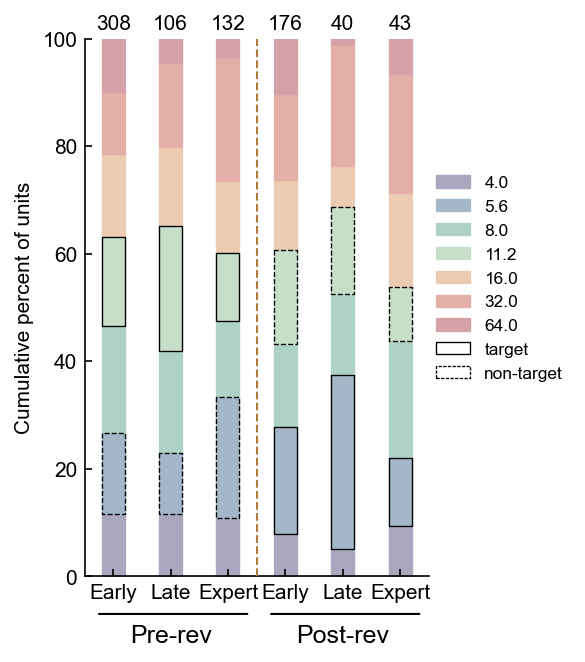

In [14]:
def plotBestFreqStack(ax,x,ylims,best_freqs,weights,width = 0.4,tntls=['-','-']):
    tones_250 = [4000,8000,16000,32000,64000]
    tones_350 = [4000,5648,8000,11260,16000,32000,64000]
    tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
    freqs_to_consider = tones_350
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = cmap(np.linspace(0,1,len(freqs_to_consider)))
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
    #colors_to_use = mpl.colors.Colormap('plasma',len(freqs_to_consider))
    
    total_weight = 0
    for tone in freqs_to_consider:
        this_tone_idx = np.equal(best_freqs,tone)
        total_weight += np.sum(weights[this_tone_idx])
        
    current_total = 0
    last_breakpoints = []
    breakpoints = [0]
    for idx,tone in enumerate(freqs_to_consider):
        this_tone_idx = np.equal(best_freqs,tone)
        this_tone_weight = np.sum(weights[this_tone_idx])
        if tone == 5648:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65,linestyle=tntls[0],edgecolor='k',zorder=10)#,hatch='XXXXXX'
        elif tone == 11260:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65,linestyle=tntls[1],edgecolor='k',zorder=10)
        else:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
        current_total += this_tone_weight
        breakpoints.append(current_total)
        
    return (breakpoints/total_weight)

def plotConnectingLines(breakpre,breakpost,X,width=0.125):
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    #colors_to_use = ['#b6888e','#80689D','#3d85c6','#78a5af','#78b0ac','#a4b49c','#4d4c55']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
        
        Y1 = [breakpre[idx],breakpost[idx]]
        Y2 = [breakpre[idx+1],breakpost[idx+1]]
        Xplot = [X[0]+width,X[1]-width]
        
        ax.fill_between(Xplot,Y1,Y2,color=colors_to_use[idx],alpha=0.125,lw=0,zorder=-30)

fig, ax = plt.subplots(figsize=(4,4.5))
#fig,ax = plt.subplots(figsize=(4,3))
breakspreEa = plotBestFreqStack(ax,0,[],pre_early_best_freqs,pre_early_weights,tntls=['--','-'])
breakspreLa = plotBestFreqStack(ax,1,[],pre_late_best_freqs,pre_late_weights,tntls=['--','-'])
#plotConnectingLines(breakspreEa,breakspreLa,[0,1])
breakspreEx = plotBestFreqStack(ax,2,[],pre_expert_best_freqs,pre_expert_weights,tntls=['--','-'])
#plotConnectingLines(breakspreLa,breakspreEx,[1,2])
breakspostEa = plotBestFreqStack(ax,3,[],post_early_best_freqs,post_early_weights,tntls=['-','--'])
#plotConnectingLines(breakspreEx,breakspostEa,[2,3])
breakspostLa = plotBestFreqStack(ax,4,[],post_late_best_freqs,post_late_weights,tntls=['-','--'])
#plotConnectingLines(breakspostEa,breakspostLa,[3,4])
breakspostEx = plotBestFreqStack(ax,5,[],post_expert_best_freqs,post_expert_weights,tntls=['-','--'])
#plotConnectingLines(breakspostLa,breakspostEx,[4,5])

tones_250 = [4000,8000,16000,32000,64000]
tones_350 = [4000,5648,8000,11260,16000,32000,64000]
tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
tones_to_use = tones_350
cmap = mpl.cm.get_cmap('Set2')
colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
for idx,tone in enumerate(tones_to_use):
    ax.fill_between([],[],[],color = colors_to_use[idx],label=str(np.floor(tone/100)/10),lw=0.65)
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=0.65, linestyle='-',label='target')
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=0.65, linestyle='--',label='non-target')

labels = ['Early','Late','Expert','Early','Late','Expert']
#labels = ['Early','Late\n\nPre-reversal','Expert','Early','Late\n\nPost-reversal','Expert']
#ax.set_xlim([-0.2,5.2])
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels(['0','20','40','60','80','100'])
ax.set_ylabel('Cumulative percent of units')

ax.legend(frameon=False,loc=[1,0.35])

ax.text(0,1.01,int(np.sum(pre_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(1,1.01,int(np.sum(pre_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(2,1.01,int(np.sum(pre_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(3,1.01,int(np.sum(post_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(4,1.01,int(np.sum(post_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(5,1.01,int(np.sum(post_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)

#ax.annotate('', xy=(-0.02, -0.1), xycoords='axes fraction', xytext=(0.48, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
#ax.annotate('', xy=(0.535, -0.1), xycoords='axes fraction', xytext=(1.035, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
#ax.annotate('Early', xy=(0.1, -0.18), xycoords='axes fraction', xytext=(0.1, -0.18),color='black',fontsize=12)
#ax.annotate('Post-rev', xy=(0.64, -0.18), xycoords='axes fraction', xytext=(0.64, -0.18),color='black',fontsize=12)
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.485, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.985, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.tight_layout()


#fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Tiange Mac Folder/Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join ('C:\\\\Users\\insan\\Desktop\\Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join ('D:\\Figures','Automated Behavior Figures','Best frequency over learning automated behavior WITH LEGEND.pdf'),transparent=False,facecolor="white")

# Old Visual Style

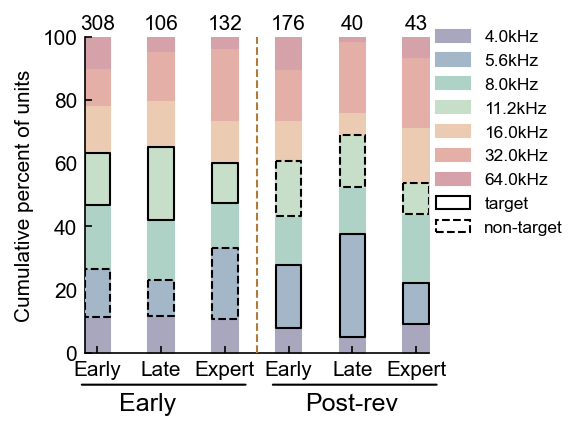

In [29]:
def plotBestFreqStack(ax,x,ylims,best_freqs,weights,width = 0.4,tntls=['-','-']):
    tones_250 = [4000,8000,16000,32000,64000]
    tones_350 = [4000,5648,8000,11260,16000,32000,64000]
    tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
    freqs_to_consider = tones_350
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = cmap(np.linspace(0,1,len(freqs_to_consider)))
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
    #colors_to_use = mpl.colors.Colormap('plasma',len(freqs_to_consider))
    
    total_weight = 0
    for tone in freqs_to_consider:
        this_tone_idx = np.equal(best_freqs,tone)
        total_weight += np.sum(weights[this_tone_idx])
        
    current_total = 0
    last_breakpoints = []
    breakpoints = [0]
    for idx,tone in enumerate(freqs_to_consider):
        this_tone_idx = np.equal(best_freqs,tone)
        this_tone_weight = np.sum(weights[this_tone_idx])
        if tone == 5648:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1,linestyle=tntls[0],edgecolor='k',zorder=10)#,hatch='XXXXXX'
        elif tone == 11260:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1,linestyle=tntls[1],edgecolor='k',zorder=10)
        else:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1)
        current_total += this_tone_weight
        breakpoints.append(current_total)
        
    return (breakpoints/total_weight)

def plotConnectingLines(breakpre,breakpost,X,width=0.125):
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    #colors_to_use = ['#b6888e','#80689D','#3d85c6','#78a5af','#78b0ac','#a4b49c','#4d4c55']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
        
        Y1 = [breakpre[idx],breakpost[idx]]
        Y2 = [breakpre[idx+1],breakpost[idx+1]]
        Xplot = [X[0]+width,X[1]-width]
        
        ax.fill_between(Xplot,Y1,Y2,color=colors_to_use[idx],alpha=0.125,lw=0,zorder=-30)

fig,ax = plt.subplots(figsize=(4,3))
breakspreEa = plotBestFreqStack(ax,0,[],pre_early_best_freqs,pre_early_weights,tntls=['--','-'])
breakspreLa = plotBestFreqStack(ax,1,[],pre_late_best_freqs,pre_late_weights,tntls=['--','-'])
#plotConnectingLines(breakspreEa,breakspreLa,[0,1])
breakspreEx = plotBestFreqStack(ax,2,[],pre_expert_best_freqs,pre_expert_weights,tntls=['--','-'])
#plotConnectingLines(breakspreLa,breakspreEx,[1,2])
breakspostEa = plotBestFreqStack(ax,3,[],post_early_best_freqs,post_early_weights,tntls=['-','--'])
#plotConnectingLines(breakspreEx,breakspostEa,[2,3])
breakspostLa = plotBestFreqStack(ax,4,[],post_late_best_freqs,post_late_weights,tntls=['-','--'])
#plotConnectingLines(breakspostEa,breakspostLa,[3,4])
breakspostEx = plotBestFreqStack(ax,5,[],post_expert_best_freqs,post_expert_weights,tntls=['-','--'])
#plotConnectingLines(breakspostLa,breakspostEx,[4,5])

tones_250 = [4000,8000,16000,32000,64000]
tones_350 = [4000,5648,8000,11260,16000,32000,64000]
tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
tones_to_use = tones_350
cmap = mpl.cm.get_cmap('Set2')
colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
for idx,tone in enumerate(tones_to_use):
    ax.fill_between([],[],[],color = colors_to_use[idx],label=str(np.floor(tone/100)/10)+'kHz',lw=1)
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=1, linestyle='-',label='target')
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=1, linestyle='--',label='non-target')

labels = ['Early','Late','Expert','Early','Late','Expert']
#labels = ['Early','Late\n\nPre-reversal','Expert','Early','Late\n\nPost-reversal','Expert']
ax.set_xlim([-0.2,5.2])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels(['0','20','40','60','80','100'])
ax.set_ylabel('Cumulative percent of units')

ax.legend(frameon=False,loc=[1,0.35])

ax.text(0,1.01,int(np.sum(pre_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(1,1.01,int(np.sum(pre_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(2,1.01,int(np.sum(pre_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(3,1.01,int(np.sum(post_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(4,1.01,int(np.sum(post_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(5,1.01,int(np.sum(post_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)

ax.annotate('', xy=(-0.02, -0.1), xycoords='axes fraction', xytext=(0.48, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.535, -0.1), xycoords='axes fraction', xytext=(1.035, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('Early', xy=(0.1, -0.18), xycoords='axes fraction', xytext=(0.1, -0.18),color='black',fontsize=12)
ax.annotate('Post-rev', xy=(0.64, -0.18), xycoords='axes fraction', xytext=(0.64, -0.18),color='black',fontsize=12)

plt.tight_layout()


#fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Tiange Mac Folder/Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join ('C:\\\\Users\\insan\\Desktop\\Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join ('D:\\Figures','Best frequency over learning automated behavior.pdf'),transparent=False,facecolor="white")

# Tuning stats

In [55]:
pre_early_5k_pcts = []
pre_early_11k_pcts = []
pre_late_5k_pcts = []
pre_late_11k_pcts = []
pre_expert_5k_pcts = []
pre_expert_11k_pcts = []
post_early_5k_pcts = []
post_early_11k_pcts = []
post_late_5k_pcts = []
post_late_11k_pcts = []
post_expert_5k_pcts = []
post_expert_11k_pcts = []

last_session = None
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    if session == last_session:
        continue
    sessionfile = ilep.loadSessionCached(act_directory,session)
    sessionfile = ilep.determineTuningCurveTones(sessionfile)
    last_session = session
    
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','AE_235','AE_236','TH_237']:
        continue
        
    if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if ilep.testInOrderTonePresentation(sessionfile):
        continue
        
    if len(np.unique(sessionfile.tuning.trial_freqs)) < 7:
        continue
        
        
        
    this_session_best_freqs = []
    this_session_weights = []
    for clust in sessionfile.clusters.good:
        best_freqs = CalculateBestFrequencies(sessionfile,clust)
        weights = np.ones_like(best_freqs) / len(best_freqs)
        this_session_best_freqs.append(best_freqs)
        this_session_weights.append(weights)
    this_session_best_freqs = np.concatenate(this_session_best_freqs)
    this_session_weights = np.concatenate(this_session_weights)
    
    mask_5k = np.equal(this_session_best_freqs,5648)
    this_session_5k = np.sum(this_session_weights[mask_5k]) / np.sum(this_session_weights)
    mask_11k = np.equal(this_session_best_freqs,11260)
    this_session_11k = np.sum(this_session_weights[mask_11k]) / np.sum(this_session_weights)
        
    if EILphases[idx] == 'pre early':
        pre_early_5k_pcts.append(this_session_5k)
        pre_early_11k_pcts.append(this_session_11k)
    if EILphases[idx] == 'pre late':
        pre_late_5k_pcts.append(this_session_5k)
        pre_late_11k_pcts.append(this_session_11k)
    if EILphases[idx] == 'pre expert':
        pre_expert_5k_pcts.append(this_session_5k)
        pre_expert_11k_pcts.append(this_session_11k)
    if EILphases[idx] == 'post early':
        post_early_5k_pcts.append(this_session_5k)
        post_early_11k_pcts.append(this_session_11k)
    if EILphases[idx] == 'post late':
        post_late_5k_pcts.append(this_session_5k)
        post_late_11k_pcts.append(this_session_11k)
    if EILphases[idx] == 'post expert':
        post_expert_5k_pcts.append(this_session_5k)
        post_expert_11k_pcts.append(this_session_11k)

pre_early_5k_pcts = np.array(pre_early_5k_pcts)
pre_early_11k_pcts = np.array(pre_early_11k_pcts)
pre_late_5k_pcts = np.array(pre_late_5k_pcts)
pre_late_11k_pcts = np.array(pre_late_11k_pcts)
pre_expert_5k_pcts = np.array(pre_expert_5k_pcts)
pre_expert_11k_pcts = np.array(pre_expert_11k_pcts)
post_early_5k_pcts = np.array(post_early_5k_pcts)
post_early_11k_pcts = np.array(post_early_11k_pcts)
post_late_5k_pcts = np.array(post_late_5k_pcts)
post_late_11k_pcts = np.array(post_late_11k_pcts)
post_expert_5k_pcts = np.array(post_expert_5k_pcts)
post_expert_11k_pcts = np.array(post_expert_11k_pcts)

909it [00:01, 617.33it/s]


In [58]:
np.mean(pre_early_5k_pcts)

0.1330197999437631

In [59]:
np.mean(pre_early_11k_pcts)

0.11883010389524037

In [63]:
data_for_stats_5k = SimpleNamespace()
data_for_stats_5k.preearly = pre_early_5k_pcts
data_for_stats_5k.prelate = pre_late_5k_pcts
data_for_stats_5k.preexpert = pre_expert_5k_pcts
data_for_stats_5k.postearly = post_early_5k_pcts
data_for_stats_5k.postlate = post_late_5k_pcts
data_for_stats_5k.postexpert = post_expert_5k_pcts
ilep.nonparametricIndependentStatsCompareToPreearly(data_for_stats_5k)

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.008840   4.0  0.002210  0.185003  0.945520  0.009770
1          context  0.022816   1.0  0.022816  1.909948  0.171071  0.024834
2  phase * context  0.044972   4.0  0.011243  0.941160  0.444984  0.047796
3         Residual  0.895949  75.0  0.011946       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.310478  0.765010 -0.434971
12  post-expert  baseline  experimental  0.459006  0.765010 -0.578485
13    post-late  baseline  experimental  0.285714  0.765010 -1.917344
14   pre-expert  baseline  experimental  1.000000  1.000000 -0.240541
15     pre-late  baseline  experimental  0.733938  0.917423  0.393926


,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-early,post-expert,False,False,175.0,two-sided,0.841848,0.989206,fdr_bh,0.048907
1,phase,-,post-early,post-late,False,False,153.0,two-sided,0.852913,0.989206,fdr_bh,0.050878
2,phase,-,post-early,pre-expert,False,False,195.0,two-sided,0.638257,0.989206,fdr_bh,0.112488
3,phase,-,post-early,pre-late,False,False,204.5,two-sided,0.453514,0.989206,fdr_bh,0.268527
4,phase,-,post-expert,post-late,False,False,112.0,two-sided,1.000000,1.000000,fdr_bh,0.000151
5,phase,-,post-expert,pre-expert,False,False,143.0,two-sided,0.814631,0.989206,fdr_bh,0.059939
6,phase,-,post-expert,pre-late,False,False,148.0,two-sided,0.678131,0.989206,fdr_bh,0.210151
7,phase,-,post-late,pre-expert,False,False,125.5,two-sided,0.811510,0.989206,fdr_bh,0.062453
8,phase,-,post-late,pre-late,False,False,130.0,two-sided,0.676340,0.989206,fdr_bh,0.221692
9,phase,-,pre-expert,pre-late,False,False,149.0,two-sided,0.890286,0.989206,fdr_bh,0.153762


In [64]:
data_for_stats_11k = SimpleNamespace()
data_for_stats_11k.preearly = pre_early_11k_pcts
data_for_stats_11k.prelate = pre_late_11k_pcts
data_for_stats_11k.preexpert = pre_expert_11k_pcts
data_for_stats_11k.postearly = post_early_11k_pcts
data_for_stats_11k.postlate = post_late_11k_pcts
data_for_stats_11k.postexpert = post_expert_11k_pcts
ilep.nonparametricIndependentStatsCompareToPreearly(data_for_stats_11k)

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.010696   4.0  0.002674  0.419611  0.794006  0.021889
1          context  0.004161   1.0  0.004161  0.652896  0.421635  0.008630
2  phase * context  0.033653   4.0  0.008413  1.320214  0.270252  0.065780
3         Residual  0.477945  75.0  0.006373       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.490750  0.499574 -0.467188
12  post-expert  baseline  experimental  0.499574  0.499574  0.620285
13    post-late  baseline  experimental  0.455758  0.499574 -0.627033
14   pre-expert  baseline  experimental  0.394313  0.499574  0.524512
15     pre-late  baseline  experimental  0.156458  0.499574 -0.877279


,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-early,post-expert,False,False,189.0,two-sided,0.528375,0.956713,fdr_bh,0.300508
1,phase,-,post-early,post-late,False,False,153.5,two-sided,0.839460,0.956713,fdr_bh,0.168159
2,phase,-,post-early,pre-expert,False,False,203.0,two-sided,0.479766,0.956713,fdr_bh,0.307331
3,phase,-,post-early,pre-late,False,False,172.5,two-sided,0.871452,0.956713,fdr_bh,0.025712
4,phase,-,post-expert,post-late,False,False,102.5,two-sided,0.707089,0.956713,fdr_bh,-0.167229
5,phase,-,post-expert,pre-expert,False,False,138.0,two-sided,0.956713,0.956713,fdr_bh,-0.000661
6,phase,-,post-expert,pre-late,False,False,113.5,two-sided,0.426569,0.956713,fdr_bh,-0.322695
7,phase,-,post-late,pre-expert,False,False,131.5,two-sided,0.632498,0.956713,fdr_bh,0.172870
8,phase,-,post-late,pre-late,False,False,108.5,two-sided,0.690551,0.956713,fdr_bh,-0.170890
9,phase,-,pre-expert,pre-late,False,False,118.5,two-sided,0.378351,0.956713,fdr_bh,-0.332434


In [66]:
data_for_stats_5k

namespace(preearly=array([0.0625    , 0.07142857, 0.10920635, 0.18918919, 0.02267574,
                          0.2       , 0.        , 0.38888889, 0.15714286, 0.125     ,
                          0.17204301, 0.16666667, 0.06451613]),
          prelate=array([0.07922705, 0.08267974, 0.        , 0.20833333]),
          preexpert=array([0.36842105, 0.04      , 0.05555556, 0.18205128]),
          postearly=array([0.13541667, 0.45833333, 0.15384615, 0.1025641 , 0.        ,
                           0.20833333, 0.17647059, 0.23913043]),
          postlate=array([0.325]),
          postexpert=array([0.21875, 0.     , 0.4    ]))

In [65]:
data_for_stats_11k

namespace(preearly=array([0.08333333, 0.21428571, 0.10753968, 0.12162162, 0.11111111,
                          0.        , 0.21428571, 0.        , 0.14285714, 0.15625   ,
                          0.05913978, 0.17307692, 0.16129032]),
          prelate=array([0.2531401 , 0.25326797, 0.16666667, 0.07291667]),
          preexpert=array([0.17105263, 0.04      , 0.        , 0.10769231]),
          postearly=array([0.20833333, 0.14583333, 0.03846154, 0.3525641 , 0.        ,
                           0.0625    , 0.35294118, 0.17391304]),
          postlate=array([0.1625]),
          postexpert=array([0.02083333, 0.1875    , 0.        ]))